In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf


### *** About the Data (bitstampUSD) ***
> 1. time_stamp (in unix time)
> 2. volume (BTC) - Volume of BTC transacted in time period
> 3. price (Currency)- Bitcoin price in Currency units 
> 4. data collected over 21 days starts from 28th September 2018 to 18th October 2018


<font color='black'>
### Questions 1:
====================================================================================================================== <br>
> ** Create tick, volume, and dollar bars. (Bar must have open, high, low, and close values.) Students can do this from first principles or clone the following repo for an implementation. **
    
====================================================================================================================== 

In [2]:
def create_bar(dataframe, column_, units):
    _bars_ = dataframe.copy()
    if column_ == 'time_stamp':
        _bars_= _bars_.resample(str(units)+'T', label='right').agg({"price":'ohlc',"volume":'sum','transaction':'sum'})
        _bars_.columns = _bars_.columns.droplevel()
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
    else:
        if column_ == 'id':
            _bars_[column_] =1

        _bars_['filter'] = _bars_[column_].cumsum()
        _bars_['group']= 0
        n = 0
        _bars_['filter'] = _bars_['filter']/units
        _bars_['filter'] = _bars_['filter'].astype(int)
        _bars_['group']= _bars_['filter']
        _bars_ = _bars_.groupby('group').agg({"time_stamp":"last","price":'ohlc',"volume":'sum','transaction':'sum'})
        
        _bars_.columns = _bars_.columns.droplevel()
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        _bars_ = _bars_.set_index('time_stamp')

    
    return _bars_

In [3]:
path = os.getcwd()

In [4]:
data = pd.read_csv(path+'/bitstampUSD_21.csv')
#data = pd.read_csv(path+"/bitstampUSD_frm_aug.csv")

data['transaction'] = data['price'] * data['volume']
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
#data = data[:-1]
data.index = data['time_stamp']

In [5]:
time_bars = create_bar(data, 'time_stamp', 40)
time_bars.to_csv(path+"/time_bars.csv")

In [6]:
dollar_bars = create_bar(data, 'transaction', 500000)
dollar_bars.to_csv(path+"/dollar_bars.csv")

In [7]:
volume_bars = create_bar(data, 'volume', 50)
volume_bars.to_csv(path+"/volume_bars.csv")

In [8]:
tick_bars = create_bar(data, 'id', 50)
tick_bars.to_csv(path+"/tick_bars.csv")

<font color='black'>
### Questions 2:
====================================================================================================================== <br>
> ** Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot the time series of the bar count. What bar type produces the most stable weekly count? And why? **  
    
======================================================================================================================

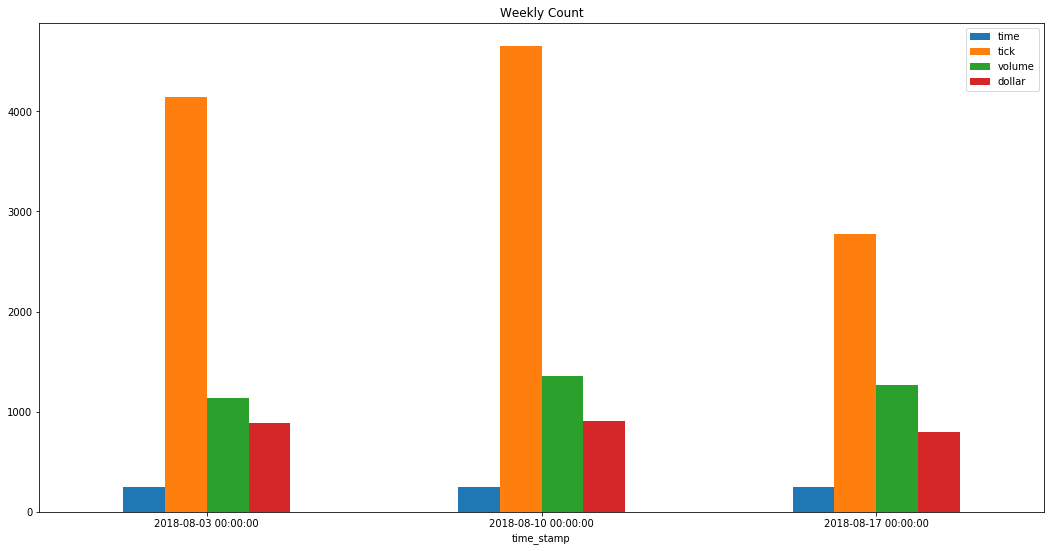

In [9]:
sample_period = 'W-FRI'
time_count = time_bars['close'].resample(sample_period, label='right').count()
tick_count = tick_bars['close'].resample(sample_period, label='right').count()
volume_count = volume_bars['close'].resample(sample_period, label='right').count()
dollar_count = dollar_bars['close'].resample(sample_period, label='right').count()

weekly_count = pd.concat([time_count, tick_count, volume_count, dollar_count], axis=1)
weekly_count.columns = ['time', 'tick', 'volume', 'dollar']
weekly_count = weekly_count.dropna()
ax = weekly_count.plot.bar(figsize=(18,9),rot=0,title='Weekly Count')

In [10]:
weekly_count

,time,tick,volume,dollar
time_stamp,,,,
2018-08-03,251,4143.0,1135.0,883.0
2018-08-10,252,4651.0,1355.0,905.0
2018-08-17,252,2772.0,1262.0,797.0



***

<font color='blue'>
### ***Analysis ***
<br>
> The Bars which has most stable weekly count is **`Time Bars`**:
* It evenly sampled across the period, though it might be high-activity period or low activity period. 
* Because of this time sampled series often exhibits poor statistical properties, it is clearly visible in below Auto Correlation plots and in Normaility plot where `Time Bars` shows higher `Kurtosis`

***

<font color='black'>
### Questions 3:
====================================================================================================================== <br>    
> ** Compute the serial correlation of each bar type and report back on which method has
the lowest serial correlation. **

======================================================================================================================

In [11]:
time_returns = np.log(time_bars['close']).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

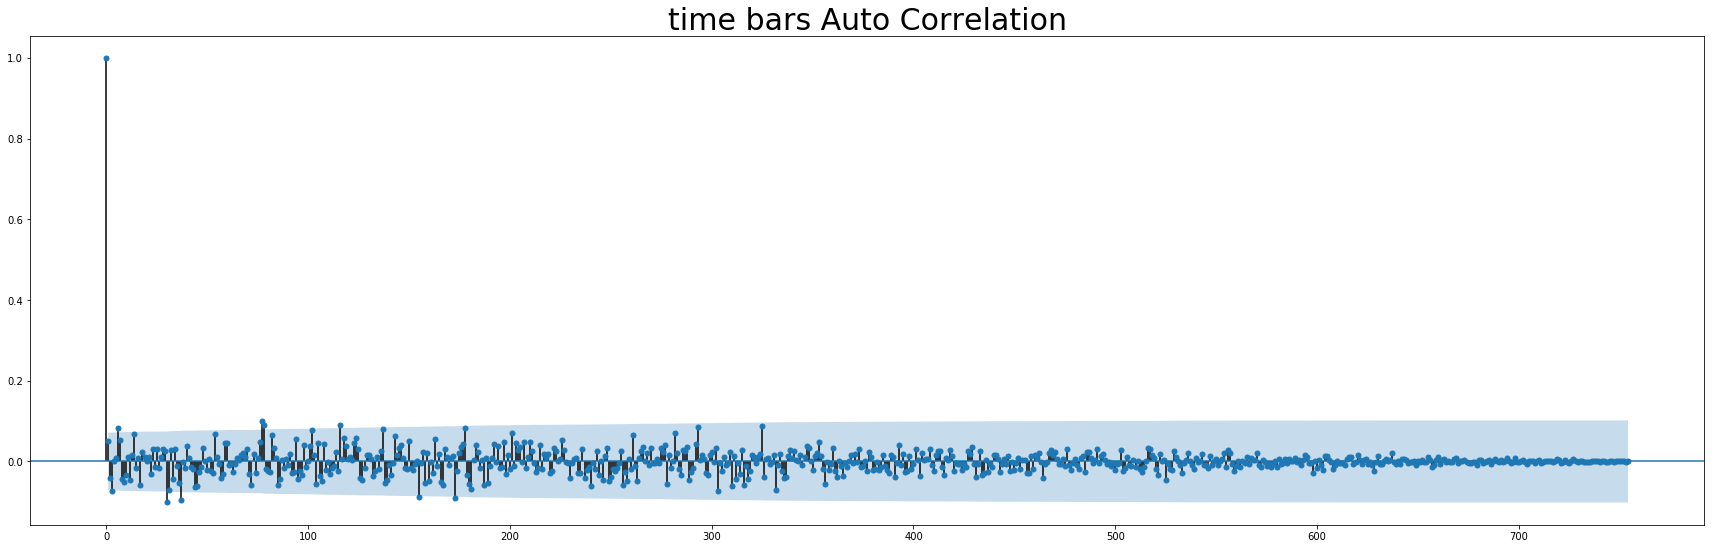

In [14]:
plt.rcParams["figure.figsize"] = (30,9)
plot_acf(time_returns)
plt.title('time bars Auto Correlation', fontsize=30)
plt.show()

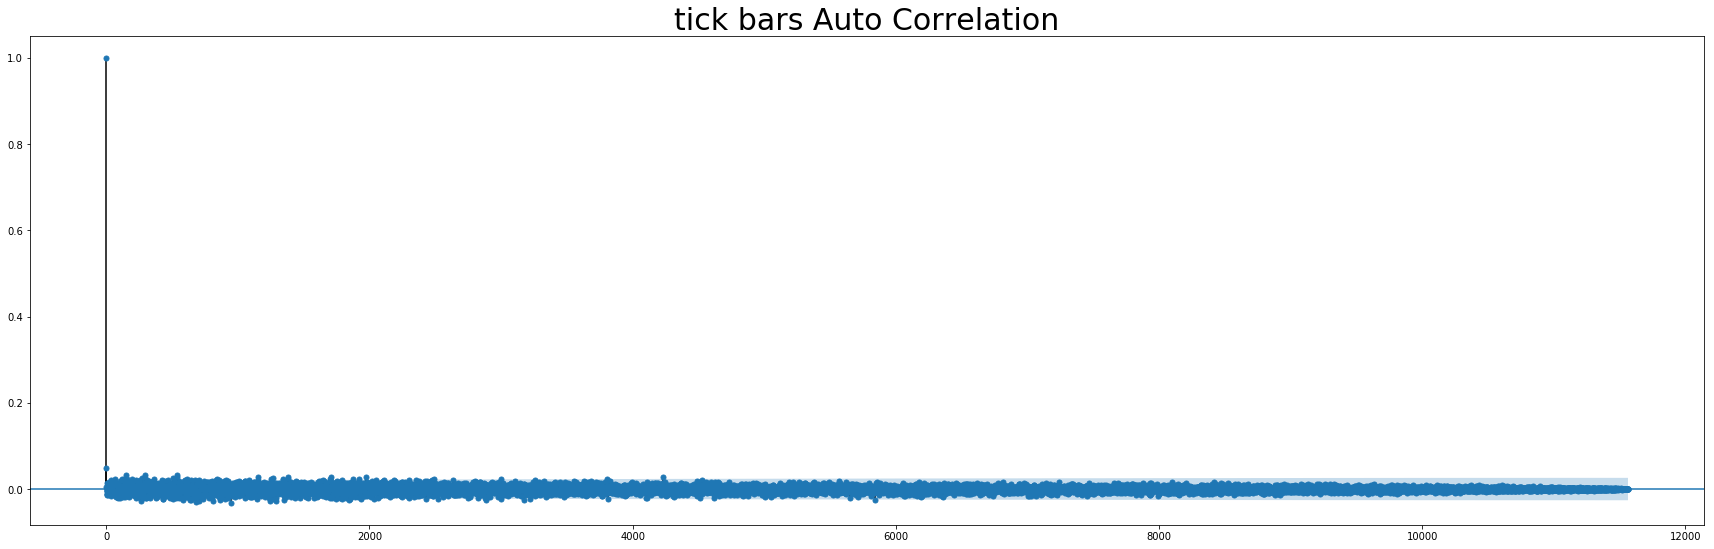

In [15]:
plt.rcParams["figure.figsize"] = (30,9)
plot_acf(tick_returns)
plt.title('tick bars Auto Correlation', fontsize=30)
plt.show()

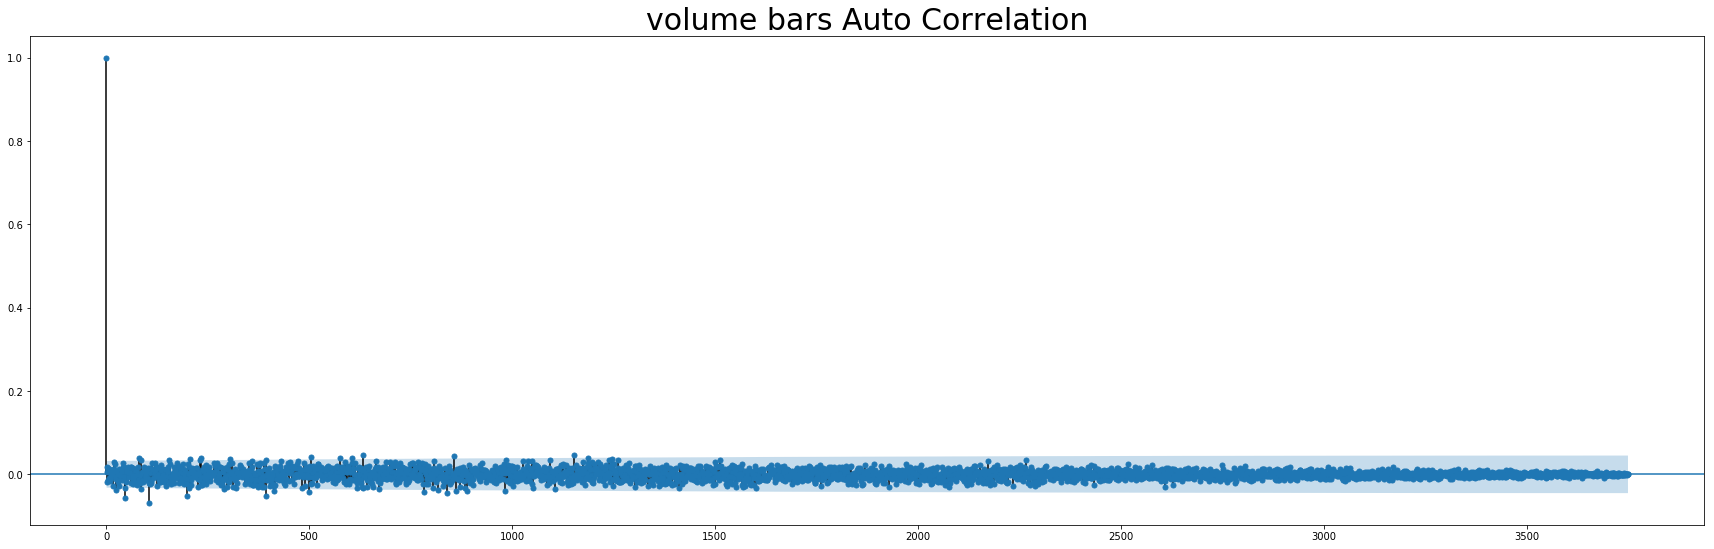

In [16]:
plt.rcParams["figure.figsize"] = (30,9)
plot_acf(volume_returns)
plt.title('volume bars Auto Correlation', fontsize=30)
plt.show()

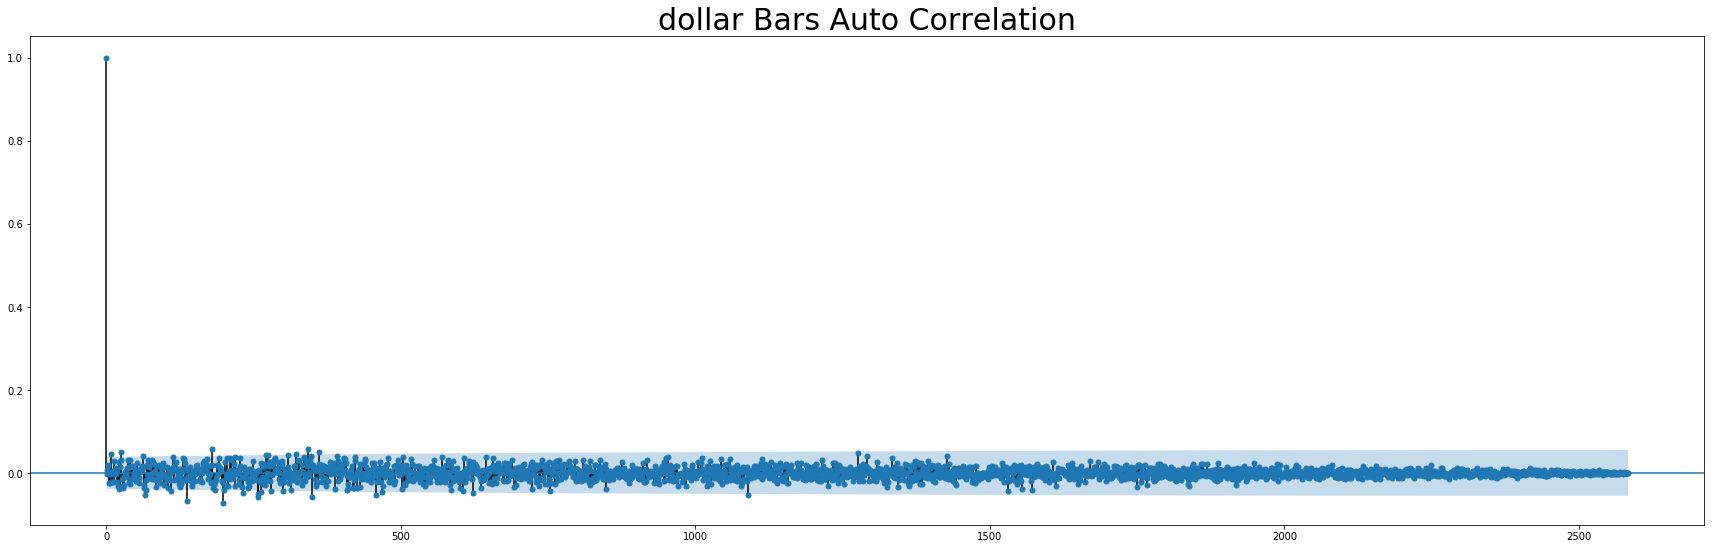

In [17]:
plt.rcParams["figure.figsize"] = (30,9)
plot_acf(dollar_returns)
plt.title('dollar Bars Auto Correlation', fontsize=30)
plt.show()

<font color='black'>
### Questions 4:
====================================================================================================================== <br>
> ** Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic? **
  
====================================================================================================================== 


In [20]:
print ('Jarque-Bera normality test statistics:')
print ('Time Bars: %s' %round(stats.jarque_bera(time_returns)[0],2))
print ('Tick Bars: %s' %round(stats.jarque_bera(tick_returns)[0],2))
print ('Volume Bars: %s' %round(stats.jarque_bera(volume_returns)[0],2))
print ('Dollar Bars: %s' %round(stats.jarque_bera(dollar_returns)[0],2))

Jarque-Bera normality test statistics:
Time Bars: 5997.72
Tick Bars: 2609.31
Volume Bars: 89.3
Dollar Bars: 52.66


In [21]:
print ("Accorning to Fisher for normal distribution skewness  should be around 0.03. The kurtosis should be 2.96 \n")

print ('*   Time Bars: Skewwness = %s , Kurtosis = %s \n' %(round(stats.skew(time_returns),2),round(stats.kurtosis(time_returns,fisher=False),2)))

print ('*   Tick Bars: Skewwness = %s , Kurtosis = %s \n' %(round(stats.skew(tick_returns),2),round(stats.kurtosis(tick_returns,fisher=False),2)))

print ('*   Volume Bar: Skewwness = %s , Kurtosis = %s \n' %(round(stats.skew(volume_returns),2),round(stats.kurtosis(volume_returns,fisher=False),2)))

print ('*   Dollar Bars: Skewwness = %s , Kurtosis = %s \n' %(round(stats.skew(dollar_returns),2),round(stats.kurtosis(dollar_returns,fisher=False),2)))

np.random.seed(0)
norm_dist = np.random.normal(size=10000)

print ('*   Random Normal Distribution: Skewwness = %s , Kurtosis = %s \n' %(round(stats.skew(norm_dist),2),round(stats.kurtosis(norm_dist,fisher=False),2)))


Accorning to Fisher for normal distribution skewness  should be around 0.03. The kurtosis should be 2.96 

*   Time Bars: Skewwness = -0.46 , Kurtosis = 16.78 

*   Tick Bars: Skewwness = 0.1 , Kurtosis = 5.32 

*   Volume Bar: Skewwness = 0.23 , Kurtosis = 3.61 

*   Dollar Bars: Skewwness = 0.24 , Kurtosis = 3.5 

*   Random Normal Distribution: Skewwness = 0.03 , Kurtosis = 2.97 



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<font color='blue'>

    
Dolla bars achieves lowest test statistics, its test statistics is 52
    
> Note:
* But Jarque-Bera normality distribution is only used for large sample sizes (> 2000) generally and in our 21 days sampled data the sample size is not more than 2000 for some Bars, So this test might not be advisable.
* By looking into Kurtosis and Skewwness (Fishers Method) we can easily see that Dollar Bars and Volume Bars follows Normal distribution

------------------------------------------------------------------------------------------------------------

<font color='black'>

======================================================================================================================
 ### Visual Inspection of Normality: 
====================================================================================================================== 


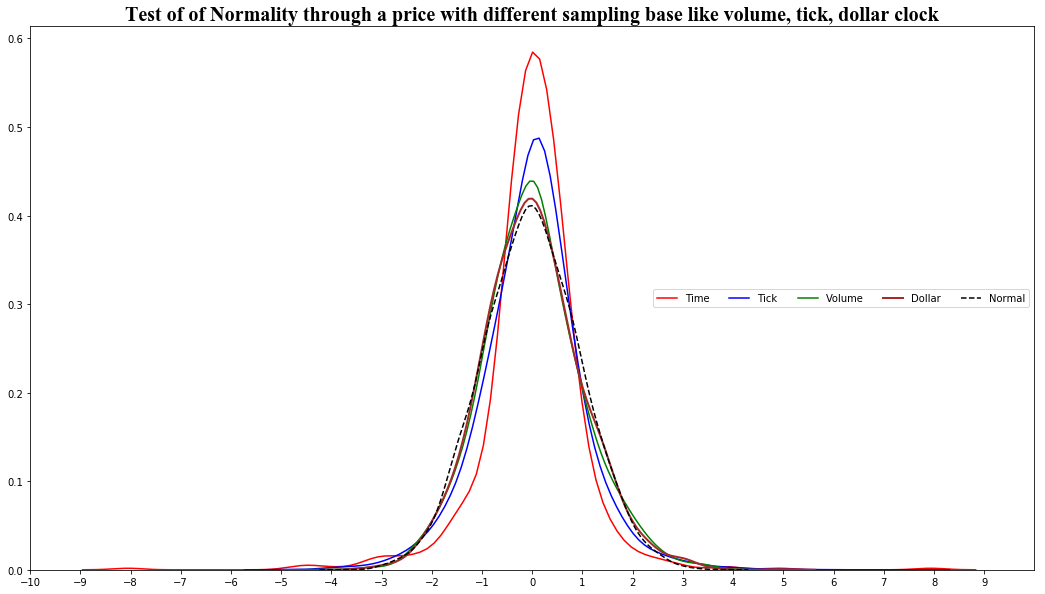

In [22]:
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()
plt.figure(figsize=(18,10))
sns.kdeplot(time_standard, label="Time", bw=0.30, color='red',linestyle="-")
sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='blue')
sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='green')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='brown')


sns.kdeplot(norm_dist, label="Normal", color='black', linestyle="--")

plt.xticks(range(-10, 10))
plt.legend(loc=7, ncol=9)
plt.title('Test of of Normality through a price with different sampling base like volume, tick, dollar clock',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-10, 10)
plt.show()